# Imports

In [174]:
import concurrent.futures
import itertools
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from scipy import stats

In [175]:
DEBUG = "CI" not in os.environ

In [176]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

In [4]:
import proteinsolver

# Parameters

In [5]:
NOTEBOOK_NAME = "global_analysis_of_protein_folding"

In [6]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/working/deep-csp-solver/notebooks/global_analysis_of_protein_folding')

In [7]:
INPUT_PATH = Path(os.getenv("DATAPKG_INPUT_DIR"))
INPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg_input_dir')

In [8]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab1/strokach/working/deep-csp-solver/notebooks/global_analysis_of_protein_folding')

In [9]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("CI_COMMIT_SHA")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT, NETWORK_NAME

(None, None, None)

# Load data

In [10]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding

aan0693_designed-PDB-files	   aan0693_SI_datasets.tar.gz.zip  swissmodel
aan0693_designed-PDB-files.gz.zip  hhpred
aan0693_SI_datasets		   hhpred2


In [11]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_designed-PDB-files

aan0693_designed-PDB-files.gz  nmr  other  other2  rd1	rd2  rd3  rd4


In [12]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets

counts_and_ec50s.tar.gz		  protein_and_dna_sequences.tar.gz
design_scripts.tgz		  stability_scores
design_structural_metrics	  stability_scores.tar.gz
design_structural_metrics.tar.gz  unfolded_state_model_params
fig1_thermodynamic_data.csv


## aan0693_SI_datasets

In [13]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets/stability_scores

rd1_stability_scores  rd3_stability_scores  ssm2_stability_scores
rd2_stability_scores  rd4_stability_scores


In [14]:
def remove_controls(df):
    df = df[
        (~df["name"].str.endswith("_hp")) & (~df["name"].str.endswith("_random")) & (~df["name"].str.endswith("_buryD"))
    ]
    return df

In [15]:
def load_stability_scores(key):
    stability_scores = pd.read_csv(
        INPUT_PATH
        / "global_analysis_of_protein_folding"
        / "aan0693_SI_datasets"
        / "stability_scores"
        / f"{key}_stability_scores",
        sep="\t",
    )
    stability_scores = remove_controls(stability_scores)

    for energy_function in ["talaris2013", "betanov15"]:
        rosetta_energies_file = (
            INPUT_PATH
            / "global_analysis_of_protein_folding"
            / "aan0693_SI_datasets"
            / "design_structural_metrics"
            / f"{key}_relax_scored_{'filtered_' if energy_function == 'betanov15' else ''}{energy_function}.sc"
        )
        if not rosetta_energies_file.is_file():
            print(f"Not loading Rosetta energies for {energy_function}!")
            continue

        before_ = len(stability_scores)
        relax_scored_filtered = pd.read_csv(
            rosetta_energies_file, sep="\t" if energy_function == "betanov15" else " +", engine="python"
        ).rename(columns={"description": "name", "total_score": f"{energy_function}_score"})
        stability_scores = stability_scores.merge(
            relax_scored_filtered[["name", f"{energy_function}_score"]], on="name", how="outer"
        )
#         assert len(stability_scores) == before_, (len(stability_scores), before_)

    stability_scores["library_name"] = key
    return stability_scores

### stability_scores

In [16]:
stability_scores = {}

In [17]:
for key in ["rd1", "rd2", "rd3", "rd4", "ssm2"]:
    stability_scores[key] = load_stability_scores(key)

Not loading Rosetta energies for talaris2013!
Not loading Rosetta energies for betanov15!


In [18]:
stability_scores["fig1"] = pd.read_csv(
    INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_SI_datasets" / "fig1_thermodynamic_data.csv"
).assign(library_name="fig1")

In [19]:
stability_scores["rd3"][
    (stability_scores["rd3"]["name"] == "HHH_rd3_0250.pdb")
]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name
4200,HHH_rd3_0250.pdb,DPKEVAREFVRAEREGNEEEAERIAKSYNIDPEEARKIFKKAF,3.0,2.65,2.5,2.8,0.3,0.44,2.21,1.06,...,1.1,1.3,0.2,0.46,0.74,0.36,0.36,-87.758,-151.755,rd3


# Load network

In [20]:
device = torch.device("cuda:1")
# device = "cpu"

batch_size = 4
num_features = 20
adj_input_size = 2
hidden_size = 128

device

device(type='cuda', index=1)

In [21]:
net = proteinsolver.models.ProteinNet(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load("protein_4xEdgeConv_bs4/e12-s1652709-d6610836.state"))
net.eval()
net = net.to(device)

# Structure probabilities

In [22]:
structure_file = "/home/kimlab1/database_data/datapkg_input_dir/global_analysis_of_protein_folding/aan0693_designed-PDB-files/rd1/EEHEE_rd1_0004.pdb"

In [23]:
pdata = proteinsolver.utils.extract_seq_and_adj(structure_file, 'A')

In [24]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
data = proteinsolver.datasets.protein.transform_edge_attr(data)
data.to(device)

proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

tensor([ -3.0604,  -1.5613,  -0.7705,  -3.2686, -12.1462,  -0.7545,  -0.0455,
         -1.8732,  -3.1426,  -6.1099,  -0.9444,  -4.8726,  -5.3841,  -0.7537,
         -3.6710,  -1.3854,  -0.6547,  -0.0167,  -2.9582,  -2.2912,  -2.2548,
         -0.0248,  -3.0484,  -2.8821,  -2.9176,  -0.0973,  -0.7629,  -4.2789,
         -1.2863,  -0.1544,  -1.8983,  -1.8271,  -2.2761,  -3.8315,  -4.4239,
         -1.5960,  -3.9461,  -2.0666,  -3.7370,  -2.0712,  -3.0086],
       device='cuda:1')

In [25]:
def get_structure_proba(net, filename):
    try:
        library_name = filename.split("_")[1]
    except IndexError:
        return np.nan, np.nan
    filepath = INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    if not filepath.is_file():
        return np.nan, np.nan
    pdata = proteinsolver.utils.extract_seq_and_adj(filepath, "A")
    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)
    log_prob = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)
    return log_prob.sum().item(), len(pdata.sequence)

In [26]:
# library = "rd4"
# stability_scores[library]["sum_log_prob"], stability_scores[library]["rd4"] = np.array(
#     [get_structure_proba(net, name) for name in stability_scores[library]["name"]]
# ).T

In [27]:
def get_mutation_proba_ssm2(net, filename, sequence):
    if not filename.endswith(".pdb"):
        filename = filename + ".pdb"

    try:
        library_name = filename.split("_")[1]
        if library_name not in ["rd1", "rd2", "rd3", "rd4"]:
            library_name = "other"
    except IndexError:
        library_name = "other"

    filepath = (
        INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    )
    if not filepath.is_file():
        return np.nan

    chain = "X" if library_name == "other" else "A"
    pdata = proteinsolver.utils.extract_seq_and_adj(filepath, chain)
    if len(pdata.sequence) != len(sequence):
        print(f"Warning, sequence lengths do not match for protien {filename}")
        return np.nan
    if sum([a == b for a, b in zip(sequence, pdata.sequence)]) < (len(sequence) * 0.8):
        print(f"Warning, sequence does not match for protien {filename}")
        return np.nan
    pdata = pdata._replace(sequence=sequence)

    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)

    log_prob = proteinsolver.utils.get_node_value(net, data.x, data.edge_index, data.edge_attr, 20)

    return log_prob.sum().item()

In [28]:
stability_scores["ssm2"]["network_score"] = [
    get_mutation_proba_ssm2(net, filename, sequence)
    for filename, sequence in stability_scores["ssm2"][["my_wt", "sequence"]].values
]

Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not match for protien EHEE_rd2_0005.pdb
Warning, sequence lengths do not m

In [29]:
def get_mutation_proba_fig1(net, filename, sequence):
    if not filename.endswith(".pdb"):
        filename = filename + ".pdb"

    try:
        library_name = filename.split("_")[1]
        if library_name not in ["rd1", "rd2", "rd3", "rd4"]:
            library_name = "other2"
    except IndexError:
        library_name = "other2"

    filepath = (
        INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    )
    if not filepath.is_file():
        return np.nan

    chain = "X" if library_name == "other2" else "A"
    pdata = proteinsolver.utils.extract_seq_and_adj(filepath, chain)
    if filename == "villin.pdb":
        pdata = pdata._replace(sequence=pdata.sequence + "SSSGSSGS")
    elif filename == "BBL.pdb":
        pdata = pdata._replace(sequence=pdata.sequence + "N")

    if len(pdata.sequence) != len(sequence):
        if filename.startswith("villin") or filename.startswith("BBL"):
            # Checked and those two are OK to truncate
            pass
        else:
            print(f"Warning, sequence lengths do not match for protien {filename} ({len(pdata.sequence)}, {len(sequence)})")
            return np.nan
    if sum([a == b for a, b in zip(sequence, pdata.sequence)]) < (len(sequence) * 0.6):
        print(f"Warning, sequences do not match for protien {filename}")
        return np.nan
    pdata = pdata._replace(sequence=sequence)

    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)

    log_prob = proteinsolver.utils.get_node_value(net, data.x, data.edge_index, data.edge_attr, 20)

    return log_prob.sum().item()

In [30]:
stability_scores["fig1"]["my_wt"] = stability_scores["fig1"]["name"].apply(
    lambda name: {"BBL": "BBL_H142W.pdb"}.get(name.split("_")[0], name.split("_")[0] + "_wt.pdb")
)

In [31]:
stability_scores["fig1"]["network_score"] = [
    get_mutation_proba_fig1(net, filename, sequence)
    for filename, sequence in stability_scores["fig1"][["my_wt", "sequence"]].values
]

In [32]:
def add_diff(df, colname):
    if f"{colname}_wt" not in df:
        before_ = len(df)
        ext = ".pdb" if not df.iloc[0]["name"].endswith(".pdb") else ""
        row_is_wt = (df["name"] + ext) == df["my_wt"]
        assert set(df[row_is_wt]["my_wt"]) == set(df["my_wt"])
        df2 = df[row_is_wt][["my_wt", colname]].rename(columns={colname: f"{colname}_wt"})
        df = df.merge(df2, on="my_wt")
        assert before_ == len(df), (before_, len(df))
    df[f"{colname}_change"] = df[f"{colname}"] - df[f"{colname}_wt"]
    return df

In [33]:
stability_scores["ssm2"].columns

Index(['name', 'sequence', 'my_wt', 'pos', 'mut', 'wt_aa', 'ec50_t',
       'delta_ec50_t', 'ec50_95ci_lbound_t', 'ec50_95ci_ubound_t',
       'ec50_95ci_t', 'ec50_pred_t', 'delta_pred_vs_wt_t', 'ec50_rise_t',
       'stabilityscore_t', 'ec50_c', 'delta_ec50_c', 'ec50_95ci_lbound_c',
       'ec50_95ci_ubound_c', 'ec50_95ci_c', 'ec50_pred_c',
       'delta_pred_vs_wt_c', 'ec50_rise_c', 'stabilityscore_c',
       'ec50_rise_c_adj', 'stabilityscore_c_adj', 'consensus_ec50_rise',
       'consensus_stability_score', 'library_name', 'network_score'],
      dtype='object')

In [34]:
stability_scores["ssm2"]["consensus_stability_score2"] = (
    stability_scores["ssm2"]["stabilityscore_t"] + stability_scores["ssm2"]["stabilityscore_c"]
) / 2

for column in ["network_score", "stabilityscore_t", "stabilityscore_c", "consensus_stability_score", "consensus_stability_score2"]:
    stability_scores["ssm2"] = add_diff(stability_scores["ssm2"], column)

In [35]:
stability_scores["fig1"] = stability_scores["fig1"].rename(
    columns={"deltaGunf thermal": "dg_thermal", "deltaGunf chemical": "dg_chemical"}
)

stability_scores["fig1"]["consensus_stability_score"] = (
    stability_scores["fig1"]["stabilityscore_t"] + stability_scores["fig1"]["stabilityscore_c"]
) / 2

stability_scores["fig1"]["consensus_dg"] = (
    stability_scores["fig1"]["dg_thermal"] + stability_scores["fig1"]["dg_chemical"]
) / 2


for column in [
    "network_score",
    "stabilityscore_t",
    "stabilityscore_c",
    "consensus_stability_score",
    "dg_thermal",
    "dg_chemical",
    "consensus_dg",
    "Tm",
]:
    stability_scores["fig1"] = add_diff(stability_scores["fig1"], column)

In [42]:
def get_conf_interval(r, num):
    import math

    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return r - lower, upper - r 

In [54]:
x_col = "network_score_change"
y_col = "consensus_stability_score_change"
library = "ssm2"

correlations = []

for my_wt, gp in stability_scores[library].groupby("my_wt"):
    x = gp[[x_col, y_col]].dropna()
    if x.empty:
        print(f"Skipping {my_wt}!")
        continue
    corr = stats.spearmanr(x[x_col], x[y_col])
    corr_conf = get_conf_interval(corr[0], len(x))
    correlations.append(
        {"my_wt": my_wt, "corr": corr[0], "pvalue": corr[1], "corr_lower_bound": corr_conf[0], "corr_upper_bound": corr_conf[1]}
    )
correlations_df = pd.DataFrame(correlations, columns=correlations[0].keys())
#     plt.title(f"Spearman R: {corr[0]:.4f} ({corr[1]:.3f})")
#     plt.plot(x[x_col], x[y_col], "r.")
#     plt.suptitle(my_wt)
#     plt.show()

Skipping EHEE_0882.pdb!
Skipping EHEE_rd2_0005.pdb!
Skipping EHEE_rd3_0015.pdb!
Skipping HHH_0142.pdb!


In [56]:
correlations_df

,my_wt,corr,pvalue,corr_lower_bound,corr_upper_bound
0,EEHEE_rd3_0037.pdb,0.394061,3.410247e-30,0.061187,0.057883
1,EEHEE_rd3_1498.pdb,0.355707,1.569278e-24,0.063095,0.060011
2,EEHEE_rd3_1702.pdb,0.127381,3.781320e-04,0.069910,0.068666
3,EEHEE_rd3_1716.pdb,0.343034,8.022096e-23,0.063676,0.060672
4,HEEH_rd2_0779.pdb,0.538652,1.591931e-59,0.051963,0.048164
5,HEEH_rd3_0223.pdb,0.341431,1.302559e-22,0.063748,0.060754
6,HEEH_rd3_0726.pdb,0.270605,1.793569e-14,0.066536,0.064048
7,HEEH_rd3_0872.pdb,0.270576,1.805785e-14,0.066537,0.064049
8,HHH_rd2_0134.pdb,0.266387,4.678677e-14,0.066679,0.064223
9,HHH_rd3_0138.pdb,0.449063,9.982651e-40,0.058060,0.054500


In [102]:
category_colors = {
    **{c: cmap(0) for c in category_names if c.startswith("mae") or c.startswith("rmsd")},
    **{c: cmap(1) for c in category_names if not c.startswith("mae") and not c.startswith("rmsd")},
}

NameError: name 'category_names' is not defined

In [241]:
def make_spider_plot(title, row, color, ax):
    other_color = "k"

    yticks = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

    # Get a list of categories
    categories = row.index.values.tolist()

    # Set the angles of each category
    angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

    # Put the first category on top and going clockwise
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    labels = []
    for c in categories:
        cs = c.rsplit("_", 1)
        if len(cs) == 1:
            labels.append(c)
        else:
            labels.append(f"{cs[0]}\n_{cs[1]}")

    # Configure X axis
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=10)
    for c, xtick in zip(labels, ax.get_xticklabels()):
        xtick.set_color(other_color)

    # Configure Y axis
    ax.set_rlabel_position(0)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{v:.1f}" for v in yticks], color=other_color)
    ax.set_ylim(0, 0.7)

    # Configure grid
    ax.grid(color="k", linestyle=":", linewidth=0.5)

    # Plot values
    ax.plot(angles, np.r_[df["corr"], df["corr"][0]], color=color, linewidth=2, linestyle="solid")
    ax.errorbar(
        angles,
        np.r_[df["corr"], df["corr"][0]],
        color=color,
#         ecolor=other_color,
#         linewidth=2,
#         linestyle="solid",
        yerr=np.c_[df[["corr_upper_bound", "corr_lower_bound"]].values.T, df[["corr_upper_bound", "corr_lower_bound"]].values.T[:, :1]],
    )
    ax.fill(angles, np.r_[df["corr"], df["corr"][0]], color=color, alpha=0.4)

    # Add a title
    if title:
        ax.set_title(title, size=12, pad=20)


#     add_yticks(ax, angles[len(angles) // 2], yticks, yticks, color=category_colors[categories[3]])

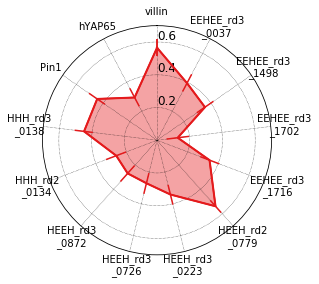

In [243]:
df = correlations_df.assign(my_wt=correlations_df["my_wt"].str.replace(".pdb", "")).set_index("my_wt")
df = pd.concat([df.iloc[-1:], df.iloc[:-1]])

cmap = plt.cm.get_cmap("Set1", 8)

fg, ax = plt.subplots(figsize=(4.5, 4.5), subplot_kw=dict(polar=True))
make_spider_plot("", df, cmap(0), ax=ax)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_mutations.svg"))
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_mutations.pdf"))
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_mutations.svg"), dpi=300)

In [234]:
correlations_df

,my_wt,corr,pvalue,corr_lower_bound,corr_upper_bound
0,EEHEE_rd3_0037.pdb,0.394061,3.410247e-30,0.061187,0.057883
1,EEHEE_rd3_1498.pdb,0.355707,1.569278e-24,0.063095,0.060011
2,EEHEE_rd3_1702.pdb,0.127381,3.781320e-04,0.069910,0.068666
3,EEHEE_rd3_1716.pdb,0.343034,8.022096e-23,0.063676,0.060672
4,HEEH_rd2_0779.pdb,0.538652,1.591931e-59,0.051963,0.048164
5,HEEH_rd3_0223.pdb,0.341431,1.302559e-22,0.063748,0.060754
6,HEEH_rd3_0726.pdb,0.270605,1.793569e-14,0.066536,0.064048
7,HEEH_rd3_0872.pdb,0.270576,1.805785e-14,0.066537,0.064049
8,HHH_rd2_0134.pdb,0.266387,4.678677e-14,0.066679,0.064223
9,HHH_rd3_0138.pdb,0.449063,9.982651e-40,0.058060,0.054500


my_wt
villin            0.564943
hYAP65            0.294843
Pin1              0.444120
HHH_rd3_0138      0.449063
HHH_rd2_0134      0.266387
HEEH_rd3_0872     0.270576
HEEH_rd3_0726     0.270605
HEEH_rd3_0223     0.341431
HEEH_rd2_0779     0.538652
EEHEE_rd3_1716    0.343034
EEHEE_rd3_1702    0.127381
EEHEE_rd3_1498    0.355707
EEHEE_rd3_0037    0.394061
Name: corr, dtype: float64

In [152]:
correlations_df.sort_values("my_wt", ascending=False)["my_wt"].str.replace(".pdb", "")).set_index("my_wt")["corr"].in

AttributeError: 'Series' object has no attribute 'set_index'

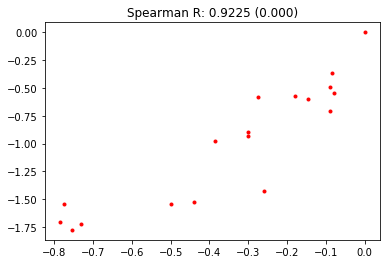

In [37]:
x_col = "consensus_stability_score_change"
y_col = "consensus_dg_change"

x = stability_scores["fig1"][[x_col, y_col]].dropna()

corr = stats.spearmanr(x[x_col], x[y_col])

plt.title(f"Spearman R: {corr[0]:.4f} ({corr[1]:.3f})")
plt.plot(x[x_col], x[y_col], "r.")

In [38]:
if "consensus_stability_score_wt" not in stability_scores["ssm2"]:
    before_ = len(stability_scores["ssm2"])
    row_is_wt = stability_scores["ssm2"]["name"] == stability_scores["ssm2"]["my_wt"]
    df = stability_scores["ssm2"][row_is_wt][["my_wt", "consensus_stability_score"]].rename(
        columns={"consensus_stability_score": "consensus_stability_score_wt"}
    )
    stability_scores["ssm2"] = stability_scores["ssm2"].merge(df, on="my_wt")
    assert before_ == len(stability_scores["ssm2"])

In [39]:
stability_scores["ssm2"]["consensus_stability_score_change"] = (
    stability_scores["ssm2"]["consensus_stability_score"] - stability_scores["ssm2"]["consensus_stability_score_wt"]
)

In [40]:
x = stability_scores["ssm2"][["sum_log_prob_change", "consensus_stability_score_change"]].dropna()

corr = stats.spearmanr(
    x["sum_log_prob_change"],
    x["consensus_stability_score_change"],
)

fg, ax = plt.subplots()

ax.plot(
    x["sum_log_prob_change"],
    x["consensus_stability_score_change"],
    'r.',
    alpha=0.5
)
ax.set_title(f"Spearman R: {corr[0]:.4f} ({corr[1]:.3f})")
fg.tight_layout()

KeyError: "['sum_log_prob_change'] not in index"

In [ ]:
def myplot(x, y, color, ax):
    x, y = pd.DataFrame({'x': x, 'y': y}).copy().dropna().values.T
    
    corr = stats.spearmanr(x, y)
    ax.plot(x, y, color=color)
    ax.set_title(f"N: {len(x):,};   Spearman R: {corr[0]:.3f} ({corr[1]:.2f})")

In [ ]:
for library_name in list(stability_scores)[:3]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].isnull())
        & ((stability_scores[library_name]["talaris2013_score"].notnull()))
    ]
    print(library_name, len(df))

In [ ]:
for library_name in list(stability_scores)[:3]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].notnull())
        & ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))

In [ ]:
for library_name in list(stability_scores)[:3]:
    df = stability_scores[library_name][
        ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))

In [ ]:
stability_scores["rd1"].head()

In [ ]:
results = []

for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = stability_scores[library].dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])
    df["domain"] = df["name"].str.split("_").str[0]
    for domain, gp in df.groupby("domain"):
        for score in ["sum_log_prob", "talaris2013_score", "betanov15_score"]:
            corr_t = stats.spearmanr(gp[score], gp["stabilityscore_t"])
            corr_c = stats.spearmanr(gp[score], gp["stabilityscore_c"])
            results.append((library, domain, score, corr_t[0], corr_t[1], corr_c[0], corr_c[1]))

In [ ]:
x_col = "sum_log_prob_normed"
df = stability_scores[library_name].dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

myplot(df[x_col], df["stabilityscore_t"], ax=axs[0])
myplot(df[x_col], df["stabilityscore_c"], ax=axs[1])

In [ ]:
x_col = "talaris2013_score_normed"
df = stability_scores[library_name].dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

myplot(df[x_col], df["stabilityscore_t"], ax=axs[0])
myplot(df[x_col], df["stabilityscore_c"], ax=axs[1])

In [ ]:
x_col = "betanov15_score_normed"
df = stability_scores[library_name].dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

myplot(df[x_col], df["stabilityscore_t"], ax=axs[0])
myplot(df[x_col], df["stabilityscore_c"], ax=axs[1])

In [ ]:
x_col = "talaris2013_score_normed"
df = stability_scores["rd1"]

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

myplot(stability_scores["rd1"][x_col], stability_scores["rd1"]["stabilityscore_t"], ax=axs[0])
myplot(stability_scores["rd1"][x_col], stability_scores["rd1"]["stabilityscore_c"], ax=axs[1])

In [ ]:
df = stability_scores["rd1"]

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(-df["talaris2013_score"] / df["sequence_lenght"], df["stabilityscore_t"], "r.")
axs[1].plot(-df["talaris2013_score"] / df["sequence_lenght"], df["stabilityscore_c"], "r.")

In [ ]:
df = stability_scores["rd1"]

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(-df["betanov15_score"] / df["sequence_lenght"], df["stabilityscore_t"], "r.")
axs[1].plot(-df["betanov15_score"] / df["sequence_lenght"], df["stabilityscore_c"], "r.")

In [ ]:
get_structure_proba(net, "rd1", "EEHEE_rd1_0001.pdb")

In [ ]:
rd3_stability_scores["sequence_lenght"] = [
    get_sequence_length(net, rd3_structure_path / name) for name in rd3_stability_scores["name"]
]

In [ ]:
print(len(rd3_stability_scores))
df = rd3_stability_scores.dropna(how='any').copy()
print(len(df))

stats.spearmanr(df["sum_log_proba"] / df['sequence_lenght'], df["stabilityscore_t"])

In [ ]:
plt.plot(df["sum_log_proba"] / df['sequence_lenght'], df["stabilityscore_t"], 'r.')

In [ ]:
df['type'] = df['name'].str.split("_").str[0]

In [ ]:
for type, gp in df.groupby("type"):
    print(type)
    c = "ec50_rise_t"
    print(stats.spearmanr(gp["sum_log_proba"] / gp['sequence_lenght'], gp[c]))
    plt.plot(gp["sum_log_proba"] / gp['sequence_lenght'], gp[c], 'r.')
    plt.show()